# Impact of rainfall temporal distribution on flooding in Lin Dyke catchment


## Project Summary

Research suggests that the temporal distribution of rainfall within a storm event can influence the nature and severity of flooding resulting from that storm event....

Testing this using synthetic rainfall events derived from FEH/ReFH2. Standard profiles usually have one peak, testing three methods for splitting the total rainfall amount normally concentrated in this one peak into multiple peaks 

Analysing impact on the extent, depth and velocity of flooding, and the spatial distribution of these variables over the catchment

In [65]:
import os
from pathlib import Path
from PIL import Image
import geopandas as gpd
from my_functions_new import *

# Define whether to filter out values <0.1
remove_little_values = True

model_directory = '../../../../FloodModelling/MeganModel_new/'

In [93]:
# Opensa raster, trims it to extent of catchment, saves a trimmed version
# and returns an arrat contianing the data, also trimmed
def open_and_clip(input_raster_fp):
    # Read in data as array
    data = rasterio.open(input_raster_fp)
    # Create a bounding box 
    minx, miny = 437000,  426500
    maxx, maxy = 445500, 434300
    bbox = box(minx, miny, maxx, maxy)
    # Insert the bbox into a GeoDataFrame
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=CRS('EPSG:27700'))     
    # Re-project into the same coordinate system as the raster data
    geo = geo.to_crs(crs=CRS('EPSG:27700'))#data.crs.data

    # Next we need to get the coordinates of the geometry in such a format
    # that rasterio wants them. This can be conducted easily with following function
    def getFeatures(gdf):
        """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
        import json
        return [json.loads(gdf.to_json())['features'][0]['geometry']]
    # Get the geometry coordinates by using the function.
    coords = getFeatures(geo)

    # Clip the raster with the polygon using the coords variable that we just created. Clipping the raster can be done easily 
    # with the mask function and specifying clip=True.
    clipped_array, out_transform = mask(data, shapes=coords, crop=True)

    # # Set -9999 to NA
    if np.isnan(np.sum(clipped_array)) == True:
        clipped_array[clipped_array < -9998] = np.nan
    else:
        clipped_array[clipped_array ==0] = np.nan

    # Modify the metadata. Let’s start by copying the metadata from the original data file.
    out_meta = data.meta.copy()
    # Parse the EPSG value from the CRS so that we can create a Proj4 string using PyCRS library 
    # (to ensure that the projection information is saved correctly) [this bit didn't work so specified manually]
    #epsg_code = int(data.crs.data['init'][5:])
    # Now we need to update the metadata with new dimensions, transform (affine) and CRS (as Proj4 text)
    out_meta.update({"driver": "GTiff","height": clipped_array.shape[1],"width": clipped_array.shape[2], 
                     "transform": out_transform, "crs": CRS('EPSG:27700')})#pycrs.parser.from_epsg_code(epsg_code).to_proj4()})

    return clipped_array[0,:,:], out_meta

In [94]:
landcover, out_meta = open_and_clip("../../../../FloodModelling/MeganModel_v1/LandCover.tif")
raster, out_meta = prepare_rainfall_scenario_raster(fp.format('Depth'), remove_little_values)
save_array_as_raster(landcover, "../../../../FloodModelling/MeganModel_v1/LandCover_clipped.tif", out_meta)

# Specify catchment area to add to plot
catchment_shp = model_directory + "CatchmentLinDyke_exported.shp"
catchment_gdf = gpd.read_file(catchment_shp)

ValueError: cannot convert float NaN to integer

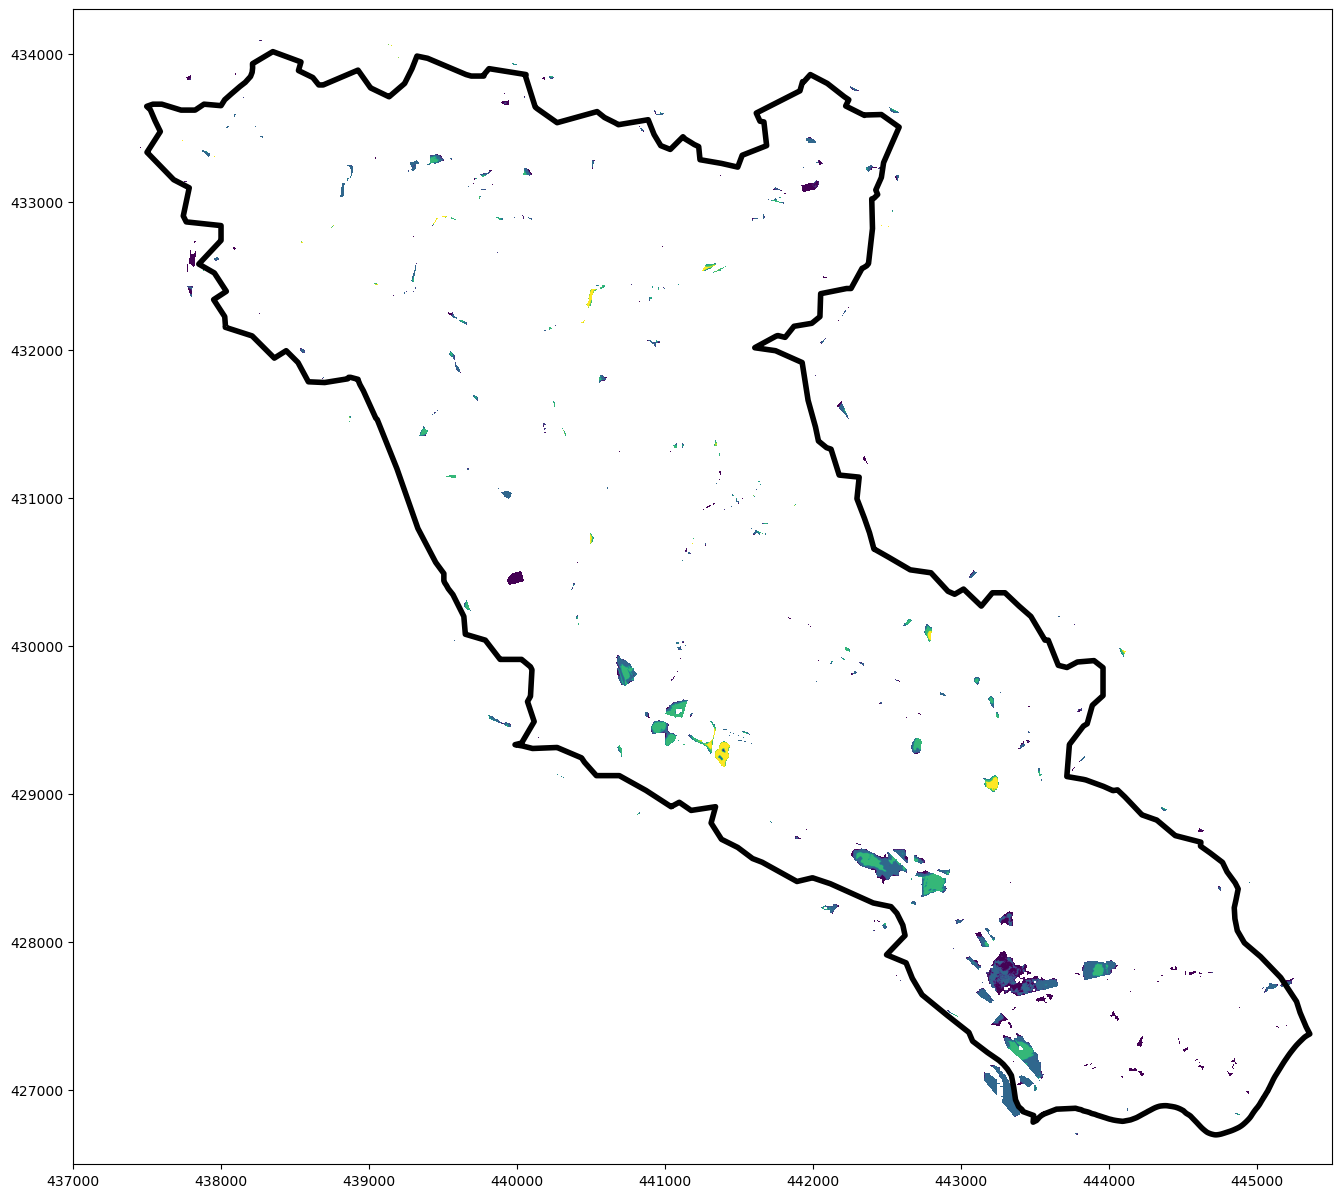

In [92]:
# print(landcover[0].shape)
# print(raster.shape)
# clipped.shape

clipped = rasterio.open(fp_for_classified_raster)

fig, ax = plt.subplots(figsize=(20, 15))
catchment_gdf.plot(ax=ax, facecolor = 'None', edgecolor = 'black', linewidth = 4)
# cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
rasterio.plot.show((clipped, 1), ax= ax)

# Close file (otherwise can't delete it, as ref to it is open)
clipped.close()



AttributeError: 'numpy.ndarray' object has no attribute 'read'

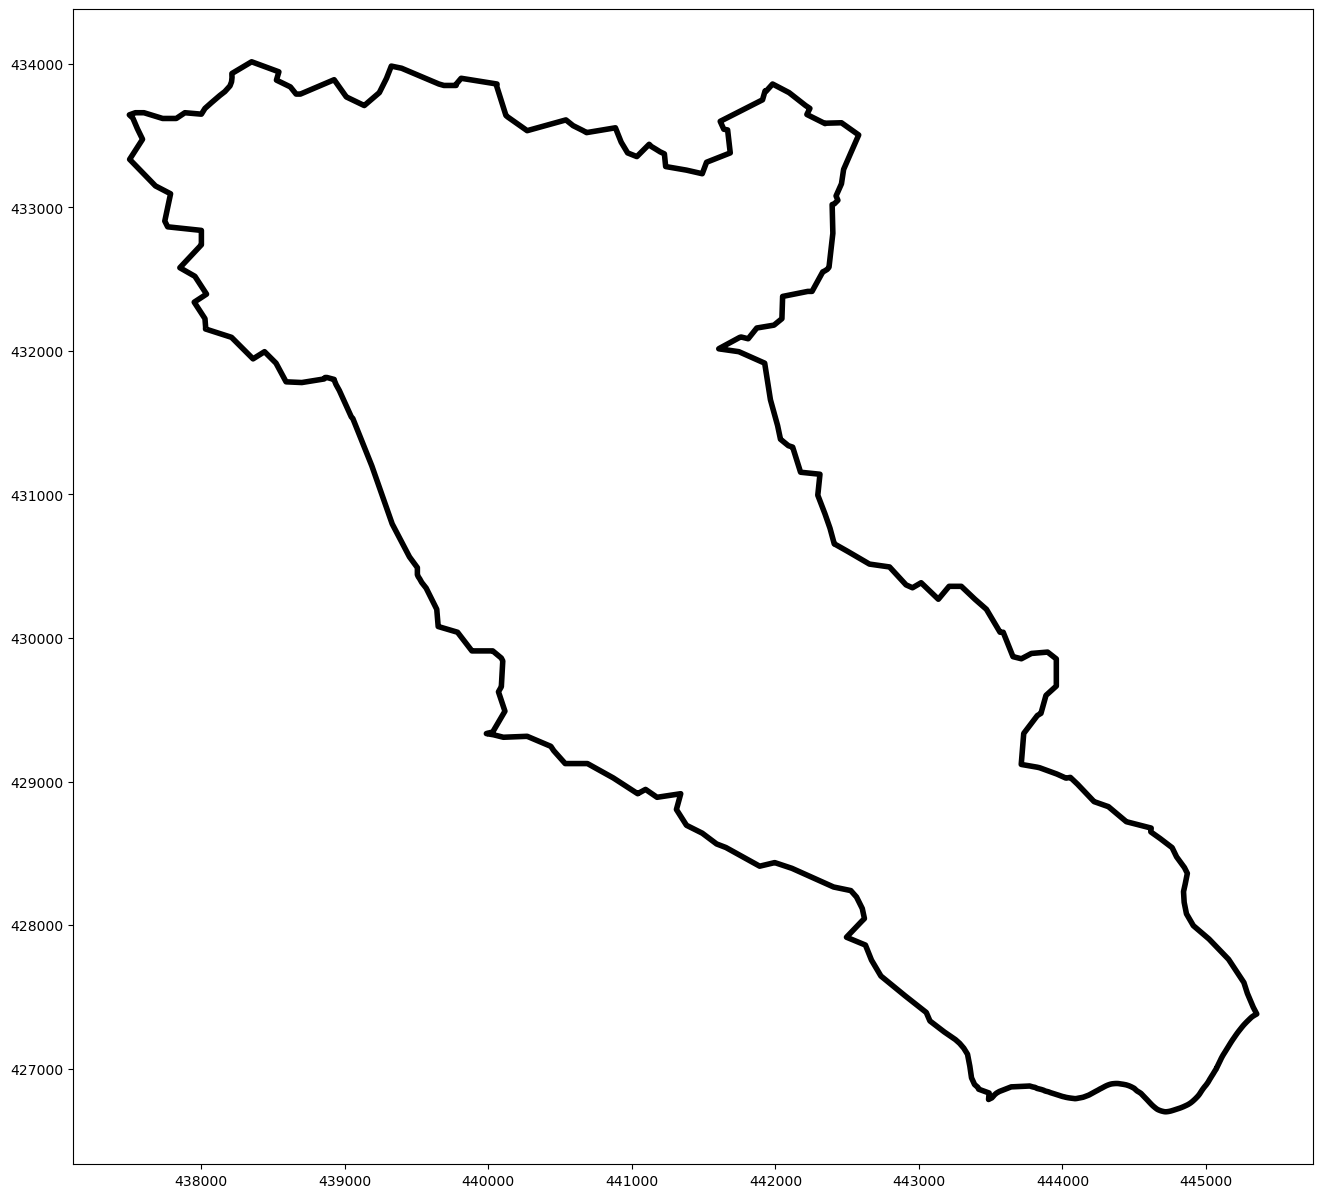

In [81]:
fig, ax = plt.subplots(figsize=(20, 15))
# cmap = mpl.colors.ListedColormap(colors_list)
catchment_gdf.plot(ax=ax, facecolor = 'None', edgecolor = 'black', linewidth = 4)
# cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)

fp_for_classified_raster = fps[0].format('Depth').replace('{} (Max).Resampled.Terrain'.format('Depth'),'{}_classified'.format('Depth'))
clipped = rasterio.open(fp_for_classified_raster)
rasterio.plot.show((raster, 1), ax= ax)


In [59]:
short_ids = ['6h_sp','6h_c1','6h_c8','6h_c15','6h_c10', '6h_c11', '6h_c3','6h_c9',
             '6h_c6','6h_c13','6h_c14', '6h_c12', '6h_c2','6h_c4','6h_c5','6h_c7',]   
methods = ['6h_single-peak',  'Cluster1', 'Cluster8', 'Cluster15', 
           'Cluster10', 'Cluster11', 'Cluster3', 'Cluster9', 'Cluster6', 'Cluster13','Cluster14', 'Cluster12', 
           'Cluster2','Cluster4', 'Cluster5', 'Cluster7']  

peak_intensity_order = [1,5,15,14,3,10,7,6,13,9,8,2,4,11,12]
len(peak_intensity_order)

15

In [36]:
fps = []
for method_num, short_id in enumerate(short_ids):
    fp = model_directory + "{}/{} (Max).Resampled.Terrain.tif".format(short_id, '{}')
    fps.append(fp)

# sp_depth_fp = fps[0].format('Depth')
# sp_fp =fps[0]

In [37]:
# Define breaks to split the depths/velocities on
breaks_depths = np.array([0, 0.3, 0.6, 1.2, 100])  
labels_depth = ['<=0.3m', '0.3-0.6m', '0.6-1.2m', '>1.2m']
breaks_velocity = np.array([0,0.25,0.5,2,100])
labels_velocity = ["<=0.25m/s", "0.25-0.5m/s", "0.5-2m/s", ">2m/s"]

velocity_counts, velocity_props = create_binned_counts_and_props(fps, 'Velocity', breaks_velocity, labels_velocity, remove_little_values)
depth_counts, depth_props = create_binned_counts_and_props(fps, 'Depth', breaks_depths, labels_depth, remove_little_values)

#  Flood extent 
To examine whether the rainfall's temporal distribution influences the total extent of flooding, the number of flooded cells and the total flooded area in km2 (incl. only cells with depth >0.1m) is compared between the profile with a single peak, and the three methods for producing multi-peaked rainfall events. 

In [38]:
# Create one dataframe with each column the total number of flooded cells for each method 
totals_df =pd.DataFrame(velocity_counts.sum(numeric_only=True)).T
totals_df = totals_df.iloc[[len(totals_df)-1]]
# Convert this to the total flooded area for each method
totals_df_area = (totals_df * 25)/1000000
totals_df_area

,6h_sp,6h_c1,6h_c8,6h_c15,6h_c10,6h_c11,6h_c3,6h_c9,6h_c6,6h_c13,6h_c14,6h_c12,6h_c2,6h_c4,6h_c5,6h_c7
0,53.729875,41.931925,39.432375,42.665775,42.1275,42.1275,43.182675,41.963825,41.9638,41.8478,43.6719,41.395325,41.931925,41.931925,46.523675,43.7065


In [39]:
# Get a list of the percentage difference between the total number of flooded cells with a single peak and the methods for
# creating multiple peaks
percent_diffs_formatted_for_plot = []
percent_diffs= []
for fp in fps:
    rainfall_scenario_name = fp.split('/')[6]
    if rainfall_scenario_name!= '6h_sp':
        percent_diffs.append(round(abs(totals_df[rainfall_scenario_name]/totals_df['6h_sp'] - 1).values[0]*100,1)) 
        percent_diffs_formatted_for_plot.append((totals_df[rainfall_scenario_name]/totals_df['6h_sp'] - 1).values[0])
# Convert values to strings, and add a + sign for positive values
# Include an empty entry for the single peak scenario
percent_diffs_formatted_for_plot =[''] + ['+' + str(round((list_item *100),2)) + '%' if list_item > 0 else str(round((list_item *100),2)) + '%'  for list_item in percent_diffs_formatted_for_plot]

## Total number of flooded cells/flooded area for each rainfall distribution (depths>0.1m)
<!-- This is assuming grid cells are 5m by 5m - but need to check this is correct.  
This plot is the same whether you use depth or velocity as the variable -->

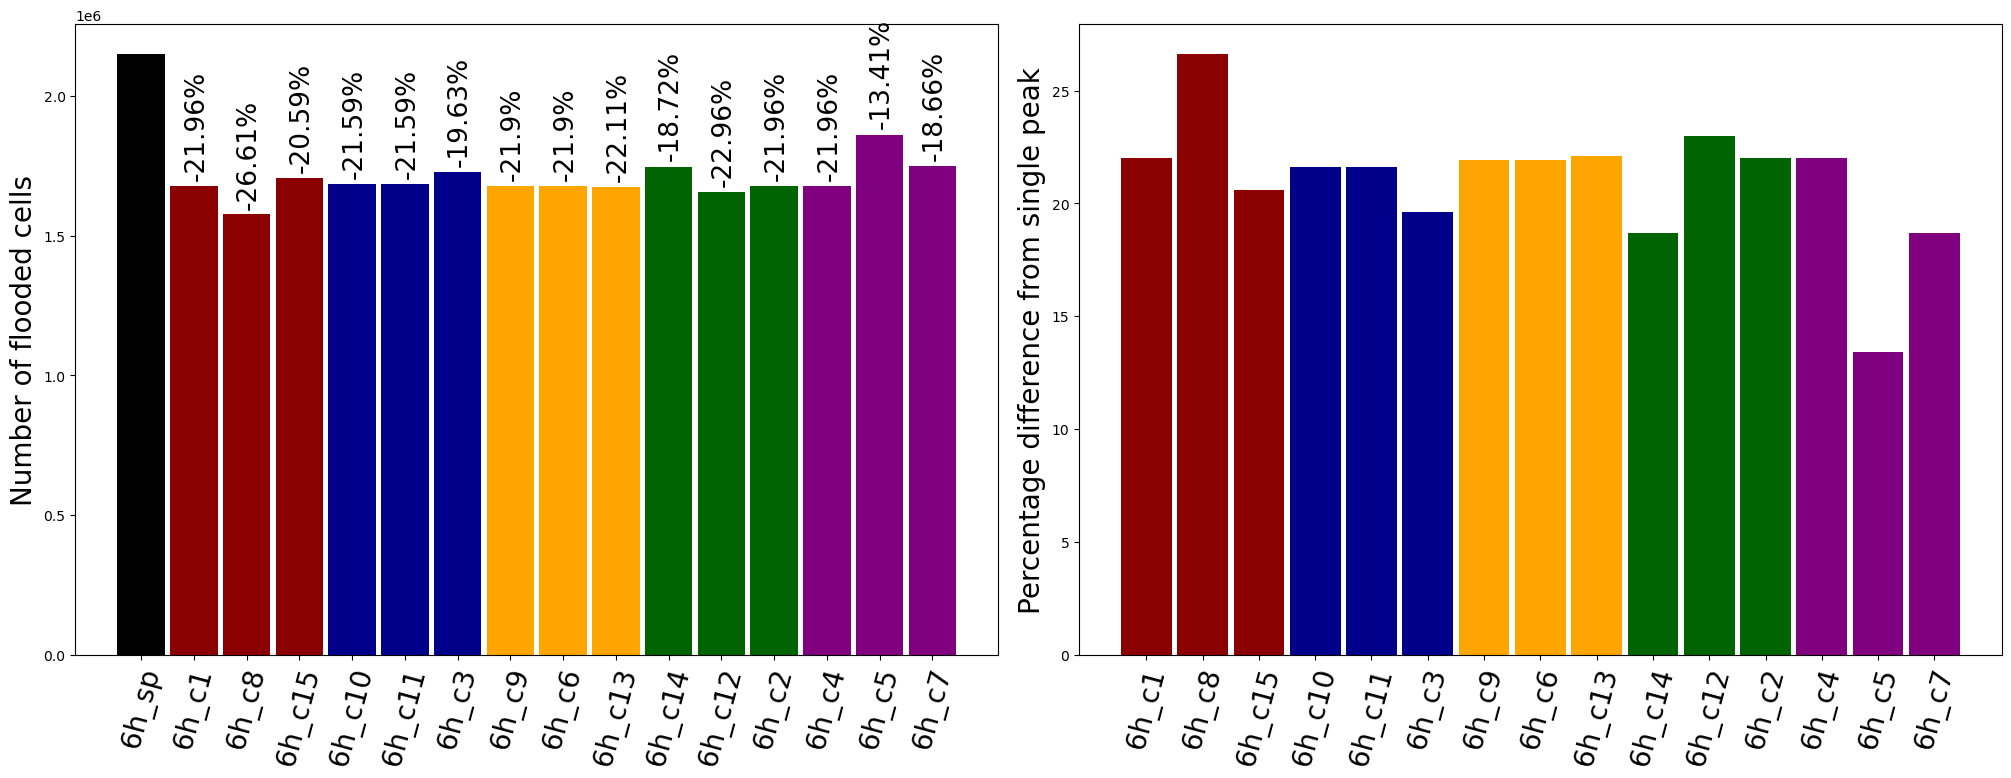

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (20,14))
y_pos = np.arange(len(totals_df.columns))
colors = ['black', 'darkred', 'darkred', 'darkred', 'darkblue', 'darkblue', 'darkblue', 'orange', 'orange', 'orange',
         'darkgreen', 'darkgreen', 'darkgreen', 'purple', 'purple', 'purple']

##############################
# Plot number of flooded cells
##############################
plt.subplot(221)
plt.bar(y_pos, totals_df.iloc[[0]].values.tolist()[0], width = 0.9, color = colors)
# Create names on the x-axis
plt.xticks(y_pos, short_ids, fontsize =20, rotation = 75)
# plt.xlabel('Method')
plt.ylabel('Number of flooded cells', fontsize =20)

xlocs, xlabs = plt.xticks(y_pos)
xlocs=[i+1 for i in range(0,19)]
xlabs=[i/2 for i in range(0,19)]

for i, v in enumerate(totals_df.iloc[[0]].values.tolist()[0]):
    plt.text(xlocs[i] - 1.2, v * 1.025, str(percent_diffs_formatted_for_plot[i]), fontsize = 19, rotation =90)

# ##############################
# # Plot flooded extent in m2
# ##############################
plt.subplot(222)
plt.bar(np.arange(len(percent_diffs)), percent_diffs, width = 0.9, color = colors[1:])
# Create names on the x-axis
plt.xticks(np.arange(len(percent_diffs)), short_ids[1:], fontsize =20, rotation = 75)
# plt.xlabel('Method')
plt.ylabel('Percentage difference from single peak', fontsize =20);

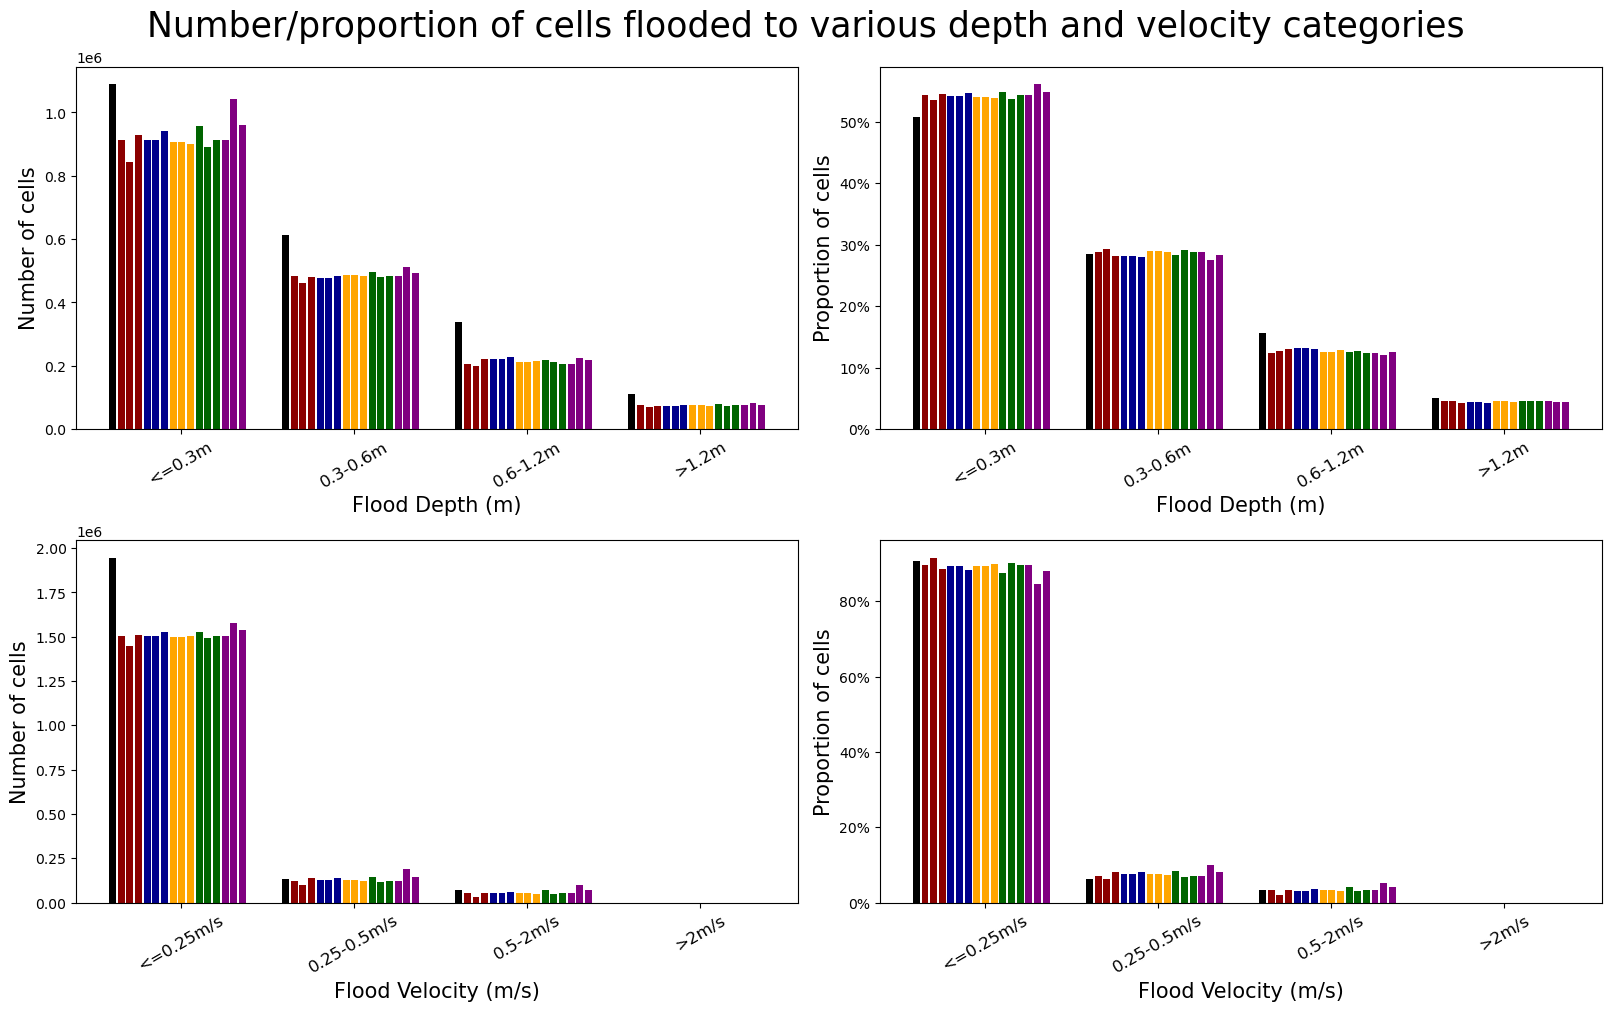

In [41]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize = (16,10))
fig.suptitle('Number/proportion of cells flooded to various depth and velocity categories', fontsize = 25)
subplot_n = [221, 222, 223, 224]
subplot_i = 0

colors = ['black', 'darkred', 'darkred', 'darkred', 'darkblue', 'darkblue', 'darkblue', 'orange', 'orange', 'orange',
         'darkgreen', 'darkgreen', 'darkgreen', 'purple', 'purple', 'purple']
units_dict = {'Depth': 'm', 'Velocity': 'm/s'}    

for row, variable in enumerate(["Depth", "Velocity"]):
    
    # Create...
    if variable == 'Depth':
        counts_df, props_df = depth_counts, depth_props 
    elif variable == 'Velocity':
        counts_df, props_df = velocity_counts, velocity_props 
    
    ################# Plot
    labels = counts_df['index']
    x = np.arange(len(counts_df['index']))
    width = 0.3
    
    # counts_df plotting
    width, DistBetweenBars, Num = 0.04, 0.01, 16 # width of each bar, distance between bars, number of bars in a group
    # calculate the width of the grouped bars (including the distance between the individual bars)
    WithGroupedBars = Num*width + (Num-1)*DistBetweenBars
    plt.subplot(subplot_n[subplot_i])
    for i in range(Num):
        plt.bar(np.arange(len(counts_df))-WithGroupedBars/2 + (width+DistBetweenBars)*i, counts_df.iloc[:,i+1], width, 
                color = colors[i])
    plt.xticks(np.arange(len(counts_df['index'])), counts_df['index'], rotation=30, fontsize = 12)
    plt.xlabel('Flood {} ({})'.format(variable, units_dict[variable]), fontsize = 15)
    plt.ylabel('Number of cells', fontsize = 15)
    # Put legend on top left plot
#     if subplot_i == 0:
#         plt.legend(counts_df.columns[1:], fontsize=15, frameon = True)
   
    # Proportions_df plotting
    subplot_i = subplot_i+ 1        
    plt.subplot(subplot_n[subplot_i])
    for i in range(Num):
        plt.bar(np.arange(len(counts_df))-WithGroupedBars/2 + (width+DistBetweenBars)*i, props_df.iloc[:,i+1], width, 
                color = colors[i])
    plt.xticks(np.arange(len(props_df['index'])), props_df['index'], rotation=30, fontsize = 12)
    plt.xlabel('Flood {} ({})'.format(variable, units_dict[variable]), fontsize = 15)
    plt.ylabel('Proportion of cells', fontsize = 15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    subplot_i = subplot_i+ 1 


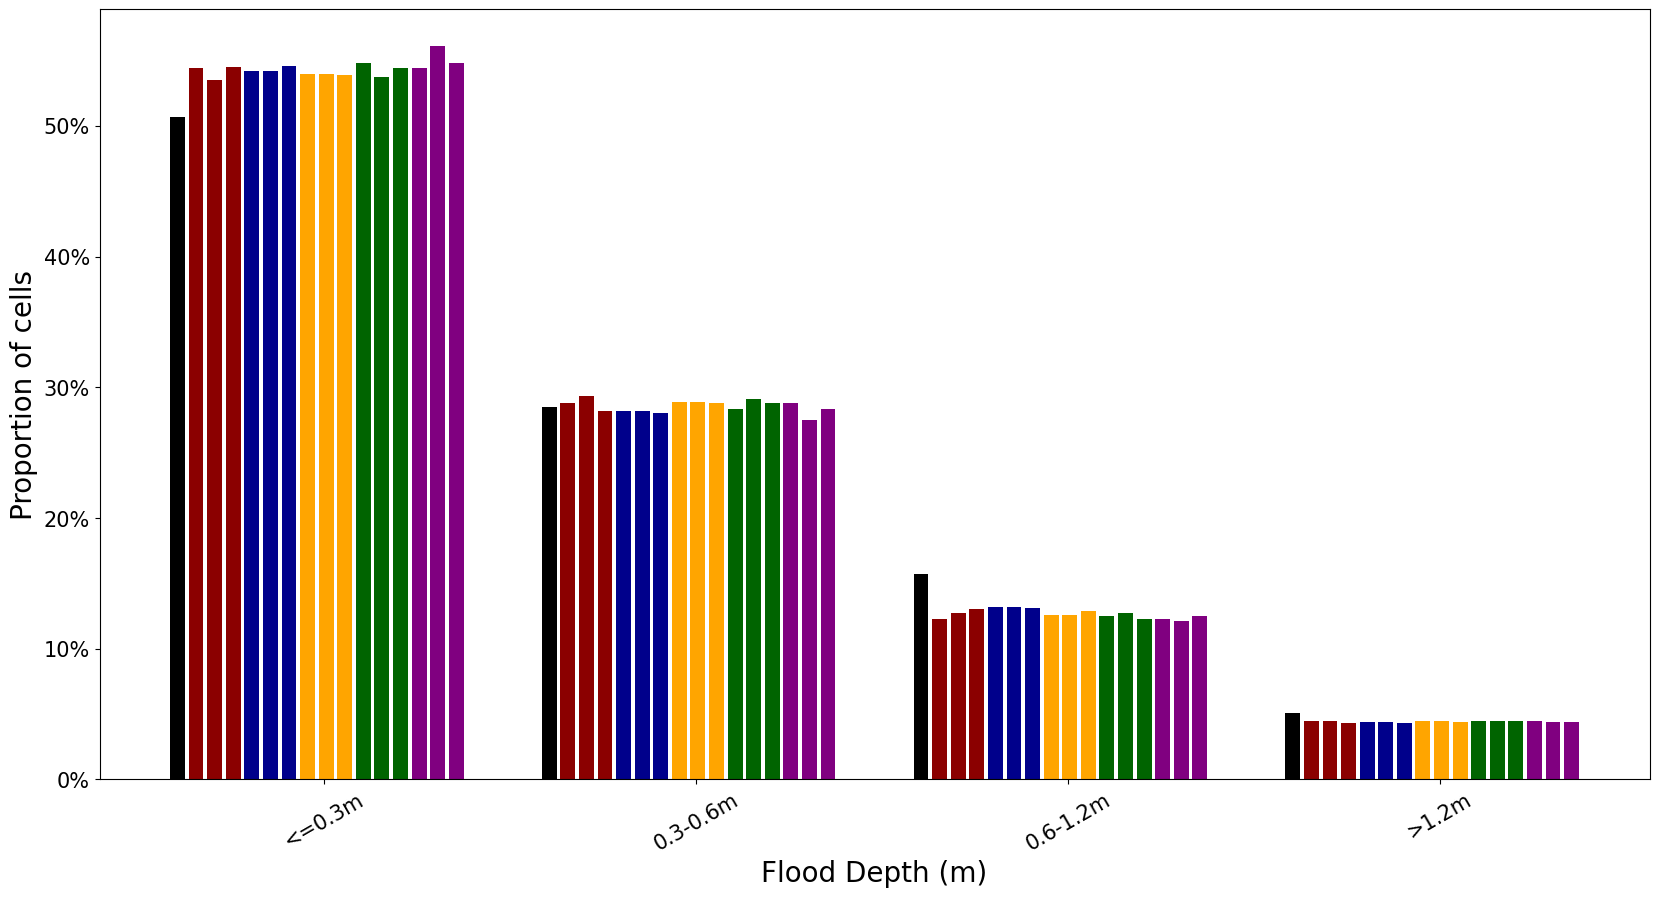

In [42]:
fig, ax =plt.subplots(figsize =(20,10))
for i in range(Num):
    plt.bar(np.arange(len(depth_counts))-WithGroupedBars/2 + (width+DistBetweenBars)*i, depth_props.iloc[:,i+1], width, 
            color = colors[i])
plt.xticks(np.arange(len(depth_props['index'])), depth_props['index'], rotation=30, fontsize = 15)
plt.yticks(fontsize=15)
plt.xlabel('Flood Depth (m)', fontsize = 20)
plt.ylabel('Proportion of cells', fontsize = 20)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

## Number of cells in which each method leads to the worst flooding (depth/velocity)
Check what happens in the case where the flood depth/velocity is equal

In [44]:
worst_case_method_depth = find_worst_case_method(fps, short_ids, 'Depth')
worst_case_method_velocity = find_worst_case_method(fps, short_ids,  'Velocity') 

In [57]:
worst_case_method_depth = worst_case_method_depth[~worst_case_method_depth['values'].isin(['multiple matches','nan'])]
worst_case_method_velocity = worst_case_method_velocity[~worst_case_method_velocity['values'].isin(['multiple matches','nan'])]
worst_case_method_depth

,values,counts
0,6h_c12,1950
1,6h_c13,3254
2,6h_c14,12087
3,6h_c15,195864
4,6h_c3,102598
5,6h_c5,1165963
6,6h_c7,3972
7,6h_c8,16505
8,6h_c9,2


<AxesSubplot:ylabel='Number of cells'>

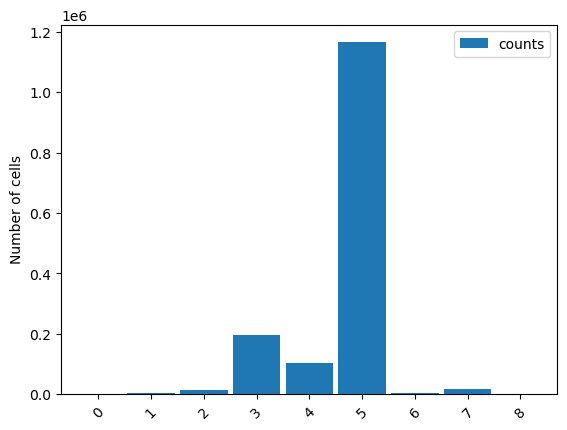

In [58]:
fig, ax  = plt.subplots()
worst_case_method_depth.plot(ax= ax, kind ='bar',width=  0.9, rot =45, ylabel = 'Number of cells')      
# def plot_worst_case_bars (ax, worst_case_method_df):
#     # Remove the np.nan values
#     worst_case_method_df = worst_case_method_df.iloc[:5,1]
#     # Set scenario names as index
#     worst_case_method_df.index = ["singlepeak", "dividetime", "subpeaktiming", "maxspread", "no maximum"]
#     # Plot
#     worst_case_method_df.plot(ax= ax, kind ='bar',width=  0.9, rot =45, ylabel = 'Number of cells')  

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (16,6))
plot_worst_case_bars(axs[0],worst_case_method_df)
plot_worst_case_bars(axs[1],worst_case_method_velocity)
fig.suptitle('Number cells where each method produces the deepest (left) and fastest (right) flooding', fontsize = 20)

## Spatial extent of flooding, by depth category (for d >0.1m) for each rainfall distribution

In [ ]:
# short_ids_less= ['6h_sp', '6h_dt', '6h_ms', '6h_spt', '6h_c1', '6h_c5', '6h_c8', '6h_c11', '6h_c12']
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(40,36))
# for number, short_id in enumerate(short_ids_less):
#     fp = 'Figs/{}/Depth_classified.png'.format(short_id)
#     make_spatial_plot(axes.flat[number],fp)
# fig.tight_layout()
# # plt.subplots_adjust(left=0.125,bottom=0.1, right=0.5, top=0.5, wspace=-0.6, hspace=0)

## Spatial extent of flooding, by velocity category (for d >0.1m) for each rainfall distribution

In [ ]:
# short_ids_less= ['6h_sp', '6h_dt', '6h_ms', '6h_spt', '6h_c1', '6h_c5', '6h_c8', '6h_c11', '6h_c12']
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(40,36))
# for number, short_id in enumerate(short_ids_less):
#     fp = 'Figs/{}/Velocity_classified.png'.format(short_id)
#     make_spatial_plot(axes.flat[number],fp)
# fig.tight_layout()
# plt.subplots_adjust(left=0.125,bottom=0.1, right=0.5, top=0.5, wspace=-0.6, hspace=0)

In [ ]:
# # Create discrete cmap
# colors_list = [mpl.cm.Blues(0.2), mpl.cm.Blues(0.5), mpl.cm.Blues(0.7),"navy"]
# cmap = mpl.colors.ListedColormap(colors_list)

# my_dict = {"dividetime":"Arcpy/depth_dividetime_reclassified.tif",
#            "maxspread":"Arcpy/depth_maxspread_reclassified.tif",
#            "subpeaktiming":"Arcpy/depth_subpeaktiming_reclassified.tif",
#            "singlepeak": "Arcpy/depth_singlepeak_reclassified.tif"}    

# plot_with_folium(my_dict, cmap, template_depth_cats)

In [ ]:
# # Create discrete cmap
# colors_list = [mpl.cm.cool(0.3), mpl.cm.cool(0.5), mpl.cm.cool(0.7), mpl.cm.cool(0.9)]
# cmap2 = mpl.colors.ListedColormap(colors_list)

# my_dict = {"dividetime":"Arcpy/velocity_dividetime_reclassified.tif",
#            "maxspread":"Arcpy/velocity_maxspread_reclassified.tif",
#            "subpeaktiming":"Arcpy/velocity_subpeaktiming_reclassified.tif",
#            "singlepeak": "Arcpy/velocity_singlepeak_reclassified.tif"}    

# plot_with_folium(my_dict, cmap2, template = template_velocity_cats)

## Difference in flood depth between a single peak and each of the multi-peaked methods
A positive difference implies that the flooding is deeper in the single peak method, whilst a negative difference implies the opposite.

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(35,30))
for number, short_id in enumerate(short_ids_less):
    fp = 'Figs/{}/Depth_difffromsinglepeak_classified.png'.format(short_id)
    make_spatial_plot(axes.flat[number],fp)
# for number, short_id in enumerate(short_ids_less):
#     fp = 'Figs/{}/Depth_difffromsinglepeak_posneg.png'.format(short_id)
#     make_spatial_plot(axes.flat[number+3],fp)    
fig.tight_layout()    

### Difference in flood velocity between a single peak and each of the multi-peaked methods
A positive difference implies that the flooding is deeper/faster in the single peak method, whilst a negative difference implies the opposite

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(35,30))
for number, short_id in enumerate(short_ids_less):
    fp = 'Figs/{}/Velocity_difffromsinglepeak_classified.png'.format(short_id)
    make_spatial_plot(axes.flat[number],fp)
for number, short_id in enumerate(short_ids_less):
    fp = 'Figs/{}/Velocity_difffromsinglepeak_posneg.png'.format(short_id)
    make_spatial_plot(axes.flat[number+3],fp)    
fig.tight_layout()    

In [ ]:
# # raster = prepare_rainfall_scenario_raster(fps[1].format('velocity'), remove_little_values)[0]
# # raster, out_meta = open_and_clip(fps[1].format('velocity'))

# # Read in data as array
# data = rasterio.open(fps[1].format('Velocity'))
# # Create a bounding box 
# minx, miny = 437000,  426500
# maxx, maxy = 445500, 434300
# bbox = box(minx, miny, maxx, maxy)
# # Insert the bbox into a GeoDataFrame
# geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0])
# # Re-project into the same coordinate system as the raster data
# geo = geo.to_crs(crs=CRS('EPSG:27700'))#data.crs.data

# # Next we need to get the coordinates of the geometry in such a format
# # that rasterio wants them. This can be conducted easily with following function
# def getFeatures(gdf):
#     """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
#     import json
#     return [json.loads(gdf.to_json())['features'][0]['geometry']]
# # Get the geometry coordinates by using the function.
# coords = getFeatures(geo)

# # Clip the raster with the polygon using the coords variable that we just created. Clipping the raster can be done easily 
# # with the mask function and specifying clip=True.
# clipped_array, out_transform = mask(data, shapes=coords, crop=True)

# # Set -9999 to NA
# clipped_array[clipped_array < -9998] = np.nan

# # Modify the metadata. Let’s start by copying the metadata from the original data file.
# out_meta = data.meta.copy()